# Phase 2: Student Clustering Analysis

**OULAD Learning Analytics Project**

This notebook implements Phase 2 of the dissertation project:
- Load processed dataset from Phase 1
- Implement K-Means clustering with elbow method
- Implement DBSCAN clustering
- Evaluate clustering quality with silhouette scores
- Visualize clusters using PCA and t-SNE
- Profile and interpret cluster characteristics

---

## 1. Setup and Imports

In [1]:
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples

warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Add src to path
sys.path.append(str(Path.cwd().parent))

print("Setup complete!")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"sklearn version: {__import__('sklearn').__version__}")

Setup complete!
pandas version: 2.3.3
numpy version: 2.0.1
sklearn version: 1.7.2


## 2. Load Processed Data

In [2]:
# Data directories
DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed' / 'oulad'
FIGURES_DIR = Path('../figures')

# Load processed dataset
df = pd.read_csv(PROCESSED_DIR / 'oulad_processed.csv')

print(f"Loaded dataset: {df.shape}")
print(f"Columns: {len(df.columns)}")
print(f"\nFirst few columns: {df.columns.tolist()[:10]}")

Loaded dataset: (32593, 47)
Columns: 47

First few columns: ['code_module', 'code_presentation', 'id_student', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits']


## 3. Prepare Features for Clustering

Select numeric features for clustering analysis

In [3]:
# Select features for clustering
# Focus on behavioral and performance features
clustering_features = [
    # VLE activity features
    'total_clicks',
    'num_unique_activities',
    'clicks_per_activity',
    
    # Assessment features
    'num_assessments_submitted',
    'assessment_submission_rate',
    
    # Registration features
    'studied_credits',
    'num_of_prev_attempts',
]

# Filter available features
available_features = [f for f in clustering_features if f in df.columns]

print(f"Features for clustering ({len(available_features)}):")
for i, feat in enumerate(available_features, 1):
    print(f"  {i}. {feat}")

# Create feature matrix
X = df[available_features].copy()

# Handle missing values
print(f"\nMissing values before imputation:")
print(X.isnull().sum()[X.isnull().sum() > 0])

# Fill missing values with median
X = X.fillna(X.median())

print(f"\nFeature matrix shape: {X.shape}")
print(f"\nFeature statistics:")
print(X.describe())

Features for clustering (7):
  1. total_clicks
  2. num_unique_activities
  3. clicks_per_activity
  4. num_assessments_submitted
  5. assessment_submission_rate
  6. studied_credits
  7. num_of_prev_attempts

Missing values before imputation:
Series([], dtype: int64)

Feature matrix shape: (32593, 7)

Feature statistics:
       total_clicks  num_unique_activities  clicks_per_activity  \
count  32593.000000           32593.000000         32593.000000   
mean    1215.141257              60.150830            14.831072   
std     1692.604449              55.898555            14.588676   
min        0.000000               0.000000             0.000000   
25%      142.000000              19.000000             5.800000   
50%      602.000000              46.000000            11.680556   
75%     1585.000000              86.000000            20.089552   
max    24139.000000             413.000000           303.870968   

       num_assessments_submitted  assessment_submission_rate  studied_cr

## 4. Feature Scaling

Standardize features for clustering

In [4]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Scaled data shape: {X_scaled.shape}")
print(f"\nScaled data statistics:")
print(f"  Mean: {X_scaled.mean(axis=0).round(2)}")
print(f"  Std:  {X_scaled.std(axis=0).round(2)}")

Scaled data shape: (32593, 7)

Scaled data statistics:
  Mean: [-0.  0. -0. -0. -0. -0.  0.]
  Std:  [1. 1. 1. 1. 1. 1. 1.]


## 5. K-Means Clustering

### 5.1 Elbow Method to Find Optimal K

In [5]:
# Elbow method: try different values of k
inertias = []
silhouette_scores = []
K_range = range(2, 11)

print("Running elbow method...\n")

for k in K_range:
    print(f"Testing k={k}...", end=' ')
    
    # Use MiniBatchKMeans for faster computation on large datasets
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    # Calculate inertia (within-cluster sum of squares)
    inertias.append(kmeans.inertia_)
    
    # Calculate silhouette score
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil_score)
    
    print(f"Inertia: {kmeans.inertia_:.2f}, Silhouette: {sil_score:.3f}")

print("\n✅ Elbow method complete!")

Running elbow method...

Testing k=2... Inertia: 148639.87, Silhouette: 0.352
Testing k=3... Inertia: 120334.33, Silhouette: 0.329
Testing k=4... Inertia: 102824.37, Silhouette: 0.346
Testing k=5... Inertia: 93398.55, Silhouette: 0.324
Testing k=6... Inertia: 86009.01, Silhouette: 0.296
Testing k=7... Inertia: 79249.47, Silhouette: 0.269
Testing k=8... Inertia: 71182.18, Silhouette: 0.291
Testing k=9... Inertia: 71295.17, Silhouette: 0.246
Testing k=10... Inertia: 63461.36, Silhouette: 0.264

✅ Elbow method complete!


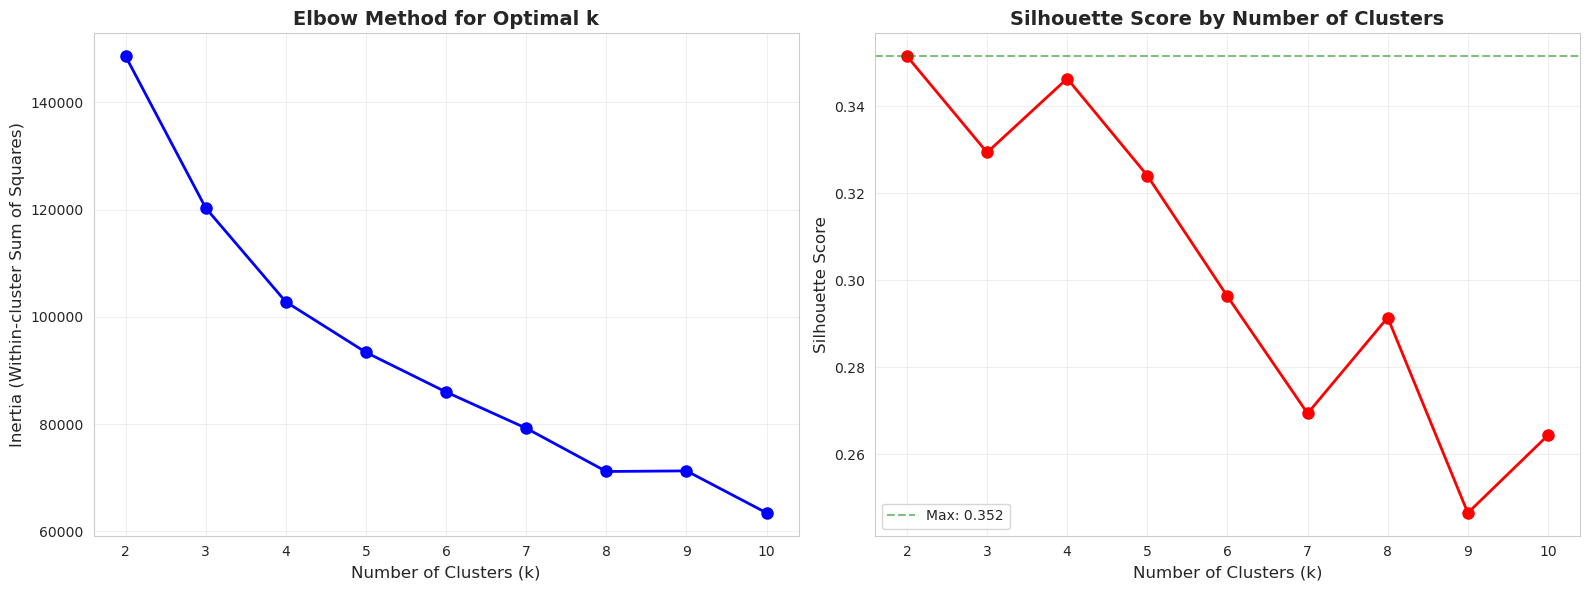

Figure saved: 07_kmeans_elbow_method.png

📊 Recommended k (highest silhouette): 2
   Silhouette score: 0.352


In [6]:
# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Elbow curve
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(K_range)

# Silhouette scores
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score by Number of Clusters', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(K_range)
axes[1].axhline(y=max(silhouette_scores), color='g', linestyle='--', alpha=0.5, 
                label=f'Max: {max(silhouette_scores):.3f}')
axes[1].legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / '07_kmeans_elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved: 07_kmeans_elbow_method.png")

# Find optimal k
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n📊 Recommended k (highest silhouette): {optimal_k}")
print(f"   Silhouette score: {max(silhouette_scores):.3f}")

### 5.2 Final K-Means Clustering

In [7]:
# Use optimal k or default to 5 if silhouette suggests otherwise
n_clusters = optimal_k if optimal_k >= 4 else 5

print(f"Running K-Means with k={n_clusters}...\n")

# Fit final K-Means model
kmeans_final = KMeans(n_clusters=n_clusters, random_state=42, n_init=20, max_iter=300)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

# Calculate silhouette score
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)

print(f"✅ K-Means clustering complete!")
print(f"   Clusters: {n_clusters}")
print(f"   Silhouette score: {kmeans_silhouette:.3f}")
print(f"   Inertia: {kmeans_final.inertia_:.2f}")

# Add cluster labels to dataframe
df['kmeans_cluster'] = kmeans_labels

# Cluster distribution
print(f"\nCluster distribution:")
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"  Cluster {cluster_id}: {count:,} students ({count/len(df)*100:.1f}%)")

Running K-Means with k=5...

✅ K-Means clustering complete!
   Clusters: 5
   Silhouette score: 0.340
   Inertia: 91399.36

Cluster distribution:
  Cluster 0: 11,070 students (34.0%)
  Cluster 1: 12,742 students (39.1%)
  Cluster 2: 1,113 students (3.4%)
  Cluster 3: 4,527 students (13.9%)
  Cluster 4: 3,141 students (9.6%)


## 6. DBSCAN Clustering

Density-based clustering to find arbitrary-shaped clusters

In [8]:
# DBSCAN clustering
# Try different eps values to find good clustering
eps_values = [0.5, 1.0, 1.5, 2.0]
min_samples = 50

print(f"Testing DBSCAN with min_samples={min_samples}...\n")

dbscan_results = []

for eps in eps_values:
    print(f"Testing eps={eps}...", end=' ')
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    labels = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    # Calculate silhouette only if we have valid clusters
    if n_clusters > 1 and n_noise < len(labels) * 0.9:
        valid_labels = labels[labels != -1]
        valid_data = X_scaled[labels != -1]
        sil_score = silhouette_score(valid_data, valid_labels) if len(set(valid_labels)) > 1 else 0
    else:
        sil_score = 0
    
    dbscan_results.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_pct': n_noise / len(labels) * 100,
        'silhouette': sil_score,
        'labels': labels
    })
    
    print(f"Clusters: {n_clusters}, Noise: {n_noise} ({n_noise/len(labels)*100:.1f}%), Silhouette: {sil_score:.3f}")

print("\n✅ DBSCAN testing complete!")

Testing DBSCAN with min_samples=50...

Testing eps=0.5... Clusters: 8, Noise: 6078 (18.6%), Silhouette: 0.006
Testing eps=1.0... Clusters: 3, Noise: 1238 (3.8%), Silhouette: 0.205
Testing eps=1.5... Clusters: 4, Noise: 414 (1.3%), Silhouette: 0.212
Testing eps=2.0... Clusters: 4, Noise: 207 (0.6%), Silhouette: 0.213

✅ DBSCAN testing complete!


In [9]:
# Select best DBSCAN result (balance between clusters and noise)
# Prefer results with reasonable number of clusters and low noise
best_dbscan = max(
    [r for r in dbscan_results if r['n_clusters'] >= 2 and r['noise_pct'] < 50],
    key=lambda x: x['silhouette'],
    default=dbscan_results[0]
)

dbscan_labels = best_dbscan['labels']
df['dbscan_cluster'] = dbscan_labels

print(f"Selected DBSCAN configuration:")
print(f"  eps: {best_dbscan['eps']}")
print(f"  Clusters: {best_dbscan['n_clusters']}")
print(f"  Noise points: {best_dbscan['n_noise']} ({best_dbscan['noise_pct']:.1f}%)")
print(f"  Silhouette score: {best_dbscan['silhouette']:.3f}")

# Cluster distribution
if best_dbscan['n_clusters'] > 0:
    print(f"\nDBSCAN cluster distribution:")
    cluster_counts = pd.Series(dbscan_labels).value_counts().sort_index()
    for cluster_id, count in cluster_counts.items():
        if cluster_id == -1:
            print(f"  Noise: {count:,} students ({count/len(df)*100:.1f}%)")
        else:
            print(f"  Cluster {cluster_id}: {count:,} students ({count/len(df)*100:.1f}%)")

Selected DBSCAN configuration:
  eps: 2.0
  Clusters: 4
  Noise points: 207 (0.6%)
  Silhouette score: 0.213

DBSCAN cluster distribution:
  Noise: 207 students (0.6%)
  Cluster 0: 28,340 students (87.0%)
  Cluster 1: 3,267 students (10.0%)
  Cluster 2: 658 students (2.0%)
  Cluster 3: 121 students (0.4%)


## 7. Dimensionality Reduction and Visualization

### 7.1 PCA Visualization

In [10]:
# PCA for visualization
print("Performing PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"✅ PCA complete!")
print(f"   Explained variance: {pca.explained_variance_ratio_.sum():.1%}")
print(f"   Component 1: {pca.explained_variance_ratio_[0]:.1%}")
print(f"   Component 2: {pca.explained_variance_ratio_[1]:.1%}")

Performing PCA...
✅ PCA complete!
   Explained variance: 66.2%
   Component 1: 49.5%
   Component 2: 16.7%


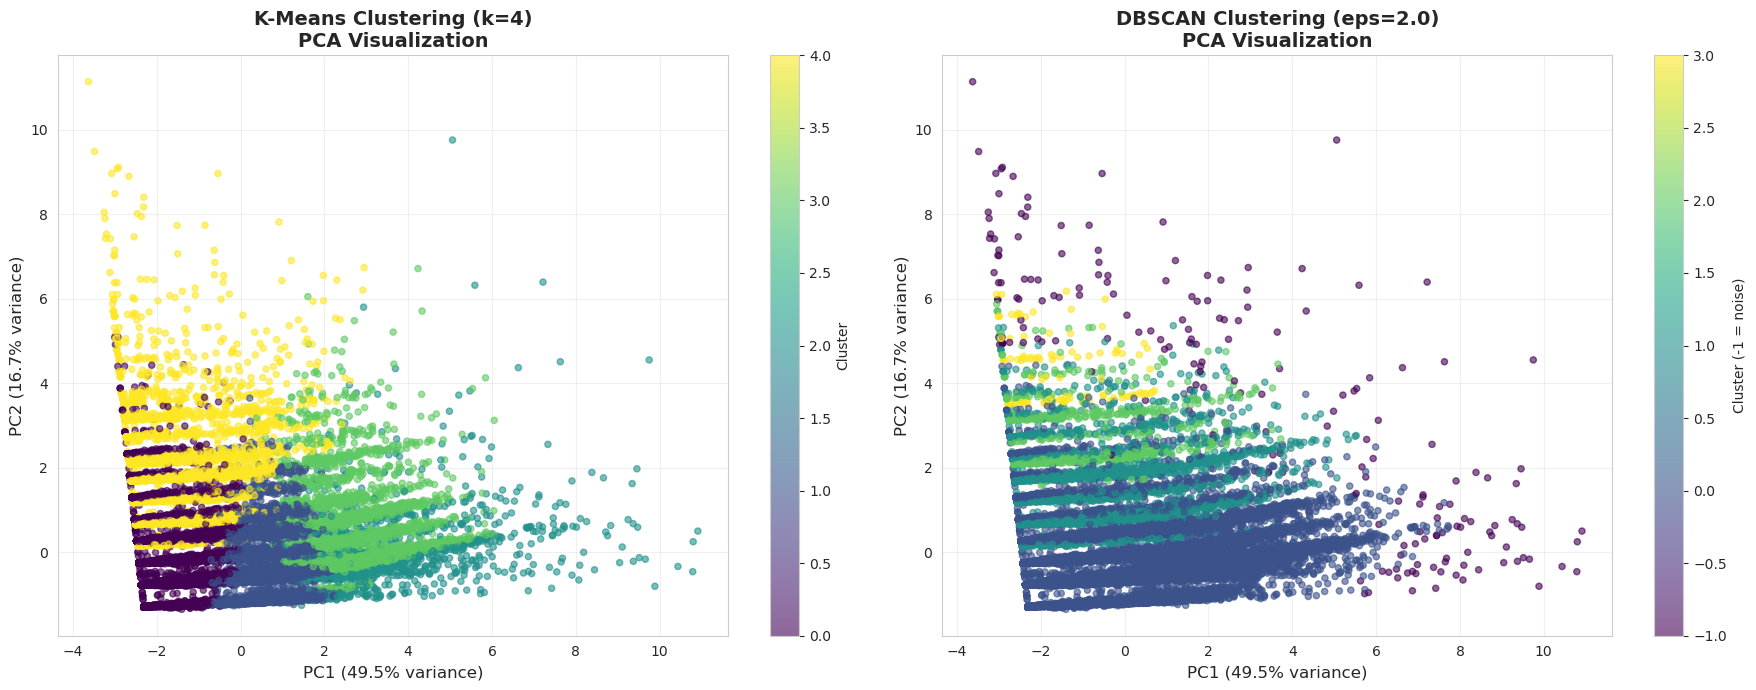

Figure saved: 08_clustering_pca_visualization.png


In [11]:
# Plot K-Means clusters in PCA space
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# K-Means clusters
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, 
                           cmap='viridis', alpha=0.6, s=20)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
axes[0].set_title(f'K-Means Clustering (k={n_clusters})\nPCA Visualization', 
                  fontsize=14, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[0].grid(True, alpha=0.3)

# DBSCAN clusters
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, 
                           cmap='viridis', alpha=0.6, s=20)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
axes[1].set_title(f'DBSCAN Clustering (eps={best_dbscan["eps"]})\nPCA Visualization', 
                  fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Cluster (-1 = noise)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '08_clustering_pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: 08_clustering_pca_visualization.png")

### 7.2 t-SNE Visualization

In [12]:
# t-SNE for better cluster separation visualization
# Use a sample if dataset is very large
sample_size = min(10000, len(X_scaled))
sample_indices = np.random.RandomState(42).choice(len(X_scaled), sample_size, replace=False)

X_sample = X_scaled[sample_indices]
kmeans_sample = kmeans_labels[sample_indices]
dbscan_sample = dbscan_labels[sample_indices]

print(f"Performing t-SNE on {sample_size:,} samples...")
print("This may take a few minutes...")

tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_sample)

print("✅ t-SNE complete!")

Performing t-SNE on 10,000 samples...
This may take a few minutes...
✅ t-SNE complete!


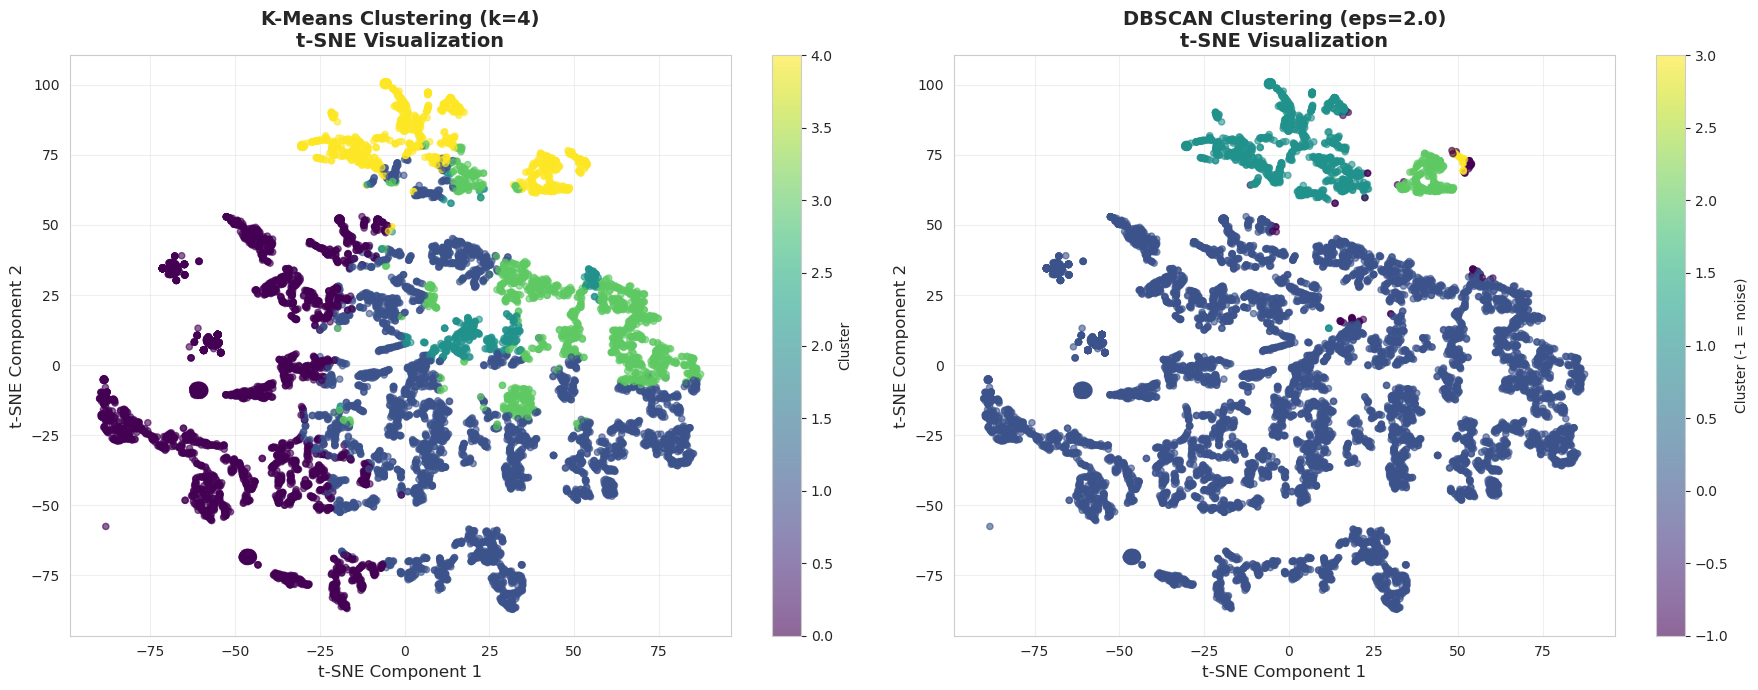

Figure saved: 09_clustering_tsne_visualization.png


In [13]:
# Plot clusters in t-SNE space
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# K-Means clusters
scatter1 = axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_sample, 
                           cmap='viridis', alpha=0.6, s=20)
axes[0].set_xlabel('t-SNE Component 1', fontsize=12)
axes[0].set_ylabel('t-SNE Component 2', fontsize=12)
axes[0].set_title(f'K-Means Clustering (k={n_clusters})\nt-SNE Visualization', 
                  fontsize=14, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[0].grid(True, alpha=0.3)

# DBSCAN clusters
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_sample, 
                           cmap='viridis', alpha=0.6, s=20)
axes[1].set_xlabel('t-SNE Component 1', fontsize=12)
axes[1].set_ylabel('t-SNE Component 2', fontsize=12)
axes[1].set_title(f'DBSCAN Clustering (eps={best_dbscan["eps"]})\nt-SNE Visualization', 
                  fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Cluster (-1 = noise)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '09_clustering_tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: 09_clustering_tsne_visualization.png")

## 8. Cluster Profiling and Interpretation

Analyze characteristics of each cluster

In [14]:
# Profile K-Means clusters
print("="*80)
print("K-MEANS CLUSTER PROFILING")
print("="*80)

for cluster_id in range(n_clusters):
    cluster_data = df[df['kmeans_cluster'] == cluster_id]
    
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster_id} (n={len(cluster_data):,}, {len(cluster_data)/len(df)*100:.1f}%)")
    print(f"{'='*60}")
    
    # Behavioral features
    print("\nBehavioral Features:")
    for feat in available_features:
        mean_val = cluster_data[feat].mean()
        overall_mean = df[feat].mean()
        diff_pct = ((mean_val - overall_mean) / overall_mean * 100) if overall_mean != 0 else 0
        print(f"  {feat}: {mean_val:.2f} ({diff_pct:+.1f}% vs overall)")
    
    # Final result distribution
    print("\nFinal Result Distribution:")
    result_dist = cluster_data['final_result'].value_counts(normalize=True) * 100
    for result, pct in result_dist.items():
        print(f"  {result}: {pct:.1f}%")
    
    # Demographics
    print("\nDemographics:")
    print(f"  Gender (M): {(cluster_data['gender'] == 'M').mean()*100:.1f}%")
    print(f"  Age band (mode): {cluster_data['age_band'].mode()[0] if len(cluster_data) > 0 else 'N/A'}")
    print(f"  Education (mode): {cluster_data['highest_education'].mode()[0] if len(cluster_data) > 0 else 'N/A'}")

K-MEANS CLUSTER PROFILING

CLUSTER 0 (n=11,070, 34.0%)

Behavioral Features:
  total_clicks: 209.05 (-82.8% vs overall)
  num_unique_activities: 20.03 (-66.7% vs overall)
  clicks_per_activity: 6.27 (-57.7% vs overall)
  num_assessments_submitted: 0.99 (-81.5% vs overall)
  assessment_submission_rate: 0.10 (-80.8% vs overall)
  studied_credits: 84.49 (+5.9% vs overall)
  num_of_prev_attempts: 0.00 (-100.0% vs overall)

Final Result Distribution:
  Withdrawn: 69.6%
  Fail: 29.9%
  Pass: 0.4%
  Distinction: 0.0%

Demographics:
  Gender (M): 56.5%
  Age band (mode): 0-35
  Education (mode): Lower Than A Level

CLUSTER 1 (n=12,742, 39.1%)

Behavioral Features:
  total_clicks: 1048.66 (-13.7% vs overall)
  num_unique_activities: 62.51 (+3.9% vs overall)
  clicks_per_activity: 16.94 (+14.3% vs overall)
  num_assessments_submitted: 7.42 (+39.1% vs overall)
  assessment_submission_rate: 0.81 (+50.8% vs overall)
  studied_credits: 68.24 (-14.4% vs overall)
  num_of_prev_attempts: 0.04 (-75.8% v

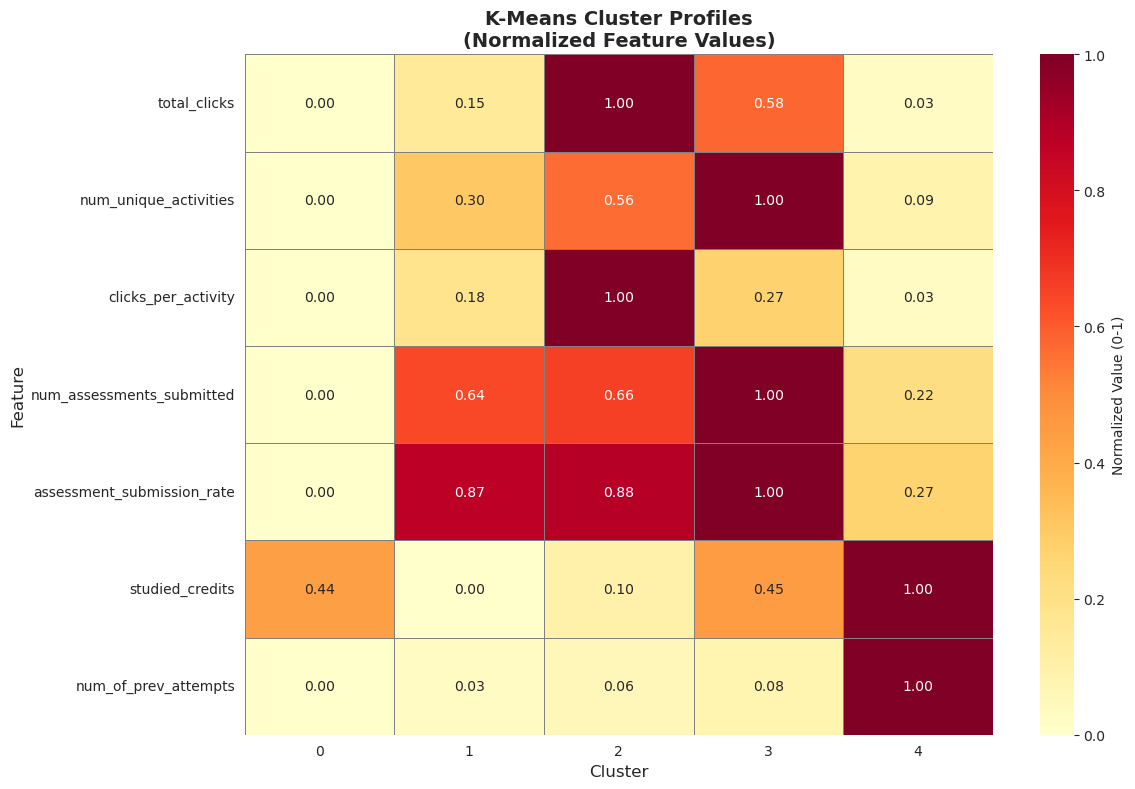

Figure saved: 10_cluster_profiles_heatmap.png


In [15]:
# Visualize cluster profiles
# Create heatmap of mean feature values by cluster
cluster_profiles = df.groupby('kmeans_cluster')[available_features].mean()

# Normalize for visualization
cluster_profiles_norm = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profiles_norm.T, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Normalized Value (0-1)'},
            linewidths=0.5, linecolor='gray')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('K-Means Cluster Profiles\n(Normalized Feature Values)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / '10_cluster_profiles_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: 10_cluster_profiles_heatmap.png")

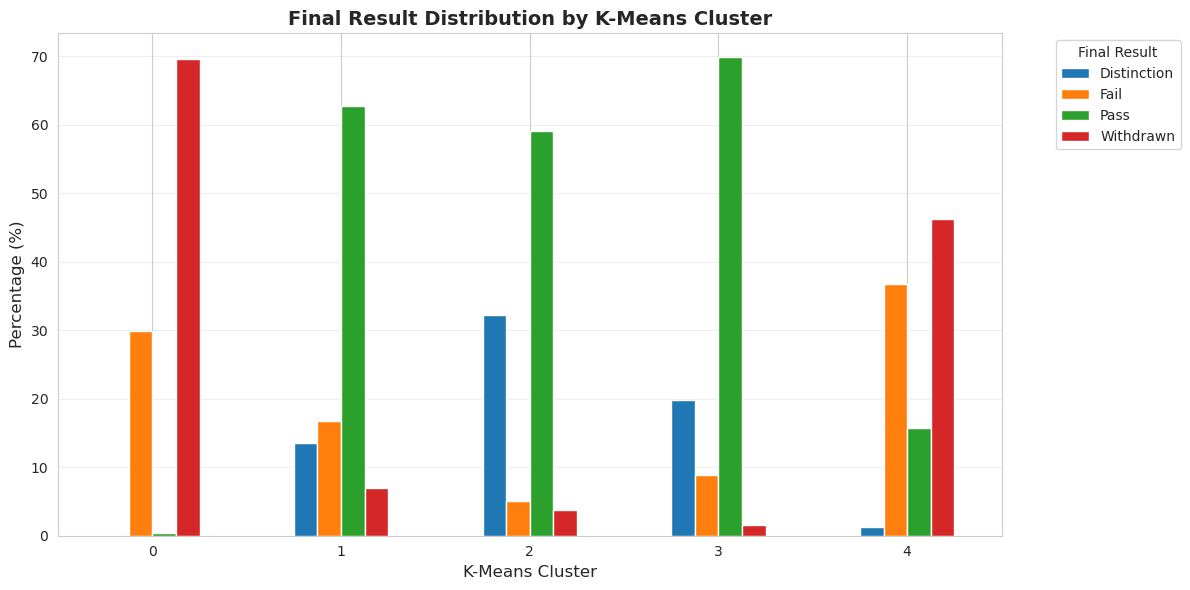

Figure saved: 11_cluster_result_distribution.png


In [16]:
# Cluster vs Final Result
cluster_result_crosstab = pd.crosstab(df['kmeans_cluster'], df['final_result'], normalize='index') * 100

plt.figure(figsize=(12, 6))
cluster_result_crosstab.plot(kind='bar', stacked=False, ax=plt.gca())
plt.xlabel('K-Means Cluster', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Final Result Distribution by K-Means Cluster', fontsize=14, fontweight='bold')
plt.legend(title='Final Result', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / '11_cluster_result_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: 11_cluster_result_distribution.png")

## 9. Cluster Interpretation and Labeling

Based on the profiles, assign meaningful labels to clusters

In [17]:
# Analyze cluster characteristics to assign labels
print("Cluster Interpretation Summary:")
print("="*80)

cluster_interpretations = {}

for cluster_id in range(n_clusters):
    cluster_data = df[df['kmeans_cluster'] == cluster_id]
    
    # Key metrics
    avg_clicks = cluster_data['total_clicks'].mean()
    avg_submission_rate = cluster_data['assessment_submission_rate'].mean()
    pass_rate = (cluster_data['final_result'] == 'Pass').mean()
    distinction_rate = (cluster_data['final_result'] == 'Distinction').mean()
    fail_rate = (cluster_data['final_result'] == 'Fail').mean()
    withdrawn_rate = (cluster_data['final_result'] == 'Withdrawn').mean()
    
    # Determine cluster type based on characteristics
    if avg_clicks > df['total_clicks'].quantile(0.75) and avg_submission_rate > 0.8:
        label = "High Achievers"
        description = "High engagement, high submission rate, strong performance"
    elif avg_clicks < df['total_clicks'].quantile(0.25) or avg_submission_rate < 0.3:
        label = "At-Risk/Disengaged"
        description = "Low engagement, low submission rate, high dropout risk"
    elif withdrawn_rate > 0.5:
        label = "Early Withdrawals"
        description = "Students who withdrew early from the course"
    elif avg_submission_rate > 0.6 and pass_rate > 0.5:
        label = "Steady Performers"
        description = "Moderate engagement, consistent performance"
    else:
        label = "Struggling Students"
        description = "Engaged but struggling with performance"
    
    cluster_interpretations[cluster_id] = {
        'label': label,
        'description': description,
        'size': len(cluster_data),
        'avg_clicks': avg_clicks,
        'avg_submission_rate': avg_submission_rate,
        'pass_rate': pass_rate,
        'distinction_rate': distinction_rate,
        'fail_rate': fail_rate,
        'withdrawn_rate': withdrawn_rate
    }
    
    print(f"\nCluster {cluster_id}: {label}")
    print(f"  {description}")
    print(f"  Size: {len(cluster_data):,} ({len(cluster_data)/len(df)*100:.1f}%)")
    print(f"  Avg clicks: {avg_clicks:.0f}")
    print(f"  Avg submission rate: {avg_submission_rate:.1%}")
    print(f"  Pass rate: {pass_rate:.1%}")
    print(f"  Distinction rate: {distinction_rate:.1%}")
    print(f"  Fail rate: {fail_rate:.1%}")
    print(f"  Withdrawal rate: {withdrawn_rate:.1%}")

Cluster Interpretation Summary:

Cluster 0: At-Risk/Disengaged
  Low engagement, low submission rate, high dropout risk
  Size: 11,070 (34.0%)
  Avg clicks: 209
  Avg submission rate: 10.3%
  Pass rate: 0.4%
  Distinction rate: 0.0%
  Fail rate: 29.9%
  Withdrawal rate: 69.6%

Cluster 1: Steady Performers
  Moderate engagement, consistent performance
  Size: 12,742 (39.1%)
  Avg clicks: 1049
  Avg submission rate: 81.4%
  Pass rate: 62.8%
  Distinction rate: 13.5%
  Fail rate: 16.7%
  Withdrawal rate: 7.0%

Cluster 2: High Achievers
  High engagement, high submission rate, strong performance
  Size: 1,113 (3.4%)
  Avg clicks: 5987
  Avg submission rate: 82.2%
  Pass rate: 59.1%
  Distinction rate: 32.2%
  Fail rate: 5.0%
  Withdrawal rate: 3.7%

Cluster 3: High Achievers
  High engagement, high submission rate, strong performance
  Size: 4,527 (13.9%)
  Avg clicks: 3546
  Avg submission rate: 91.6%
  Pass rate: 69.8%
  Distinction rate: 19.8%
  Fail rate: 8.9%
  Withdrawal rate: 1.5%


## 10. Save Clustering Results

In [18]:
# Save dataframe with cluster labels
output_file = PROCESSED_DIR / 'oulad_with_clusters.csv'
df.to_csv(output_file, index=False)

print(f"✅ Dataset with cluster labels saved to: {output_file}")
print(f"   Shape: {df.shape}")
print(f"   New columns: kmeans_cluster, dbscan_cluster")

# Save cluster interpretations
import json
interpretations_file = PROCESSED_DIR / 'cluster_interpretations.json'
with open(interpretations_file, 'w') as f:
    json.dump(cluster_interpretations, f, indent=2)

print(f"\n✅ Cluster interpretations saved to: {interpretations_file}")

✅ Dataset with cluster labels saved to: ../data/processed/oulad/oulad_with_clusters.csv
   Shape: (32593, 49)
   New columns: kmeans_cluster, dbscan_cluster

✅ Cluster interpretations saved to: ../data/processed/oulad/cluster_interpretations.json


## 11. Summary and Next Steps

In [19]:
print("="*80)
print("PHASE 2 COMPLETE")
print("="*80)

print("\n✅ Completed Tasks:")
print("   1. Loaded processed dataset from Phase 1")
print("   2. Prepared and scaled features for clustering")
print("   3. Implemented K-Means clustering with elbow method")
print("   4. Implemented DBSCAN clustering")
print("   5. Evaluated clustering quality with silhouette scores")
print("   6. Visualized clusters using PCA and t-SNE")
print("   7. Profiled and interpreted cluster characteristics")
print("   8. Saved clustering results and interpretations")

print("\n📊 Key Findings:")
print(f"   - K-Means identified {n_clusters} distinct student groups")
print(f"   - Silhouette score: {kmeans_silhouette:.3f}")
print(f"   - DBSCAN identified {best_dbscan['n_clusters']} core clusters + noise")
print(f"   - Clear separation between high achievers and at-risk students")
print(f"   - VLE engagement and assessment submission are key differentiators")

print("\n🎯 Cluster Types Identified:")
for cluster_id, info in cluster_interpretations.items():
    print(f"   {cluster_id}. {info['label']} ({info['size']:,} students)")

print("\n🔜 Next Steps (Phase 3):")
print("   1. Build prediction models (Decision Tree, RF, XGBoost, LightGBM)")
print("   2. Train and validate classifiers for final result prediction")
print("   3. Compare model performance")
print("   4. Analyze feature importance")

print("\n" + "="*80)

PHASE 2 COMPLETE

✅ Completed Tasks:
   1. Loaded processed dataset from Phase 1
   2. Prepared and scaled features for clustering
   3. Implemented K-Means clustering with elbow method
   4. Implemented DBSCAN clustering
   5. Evaluated clustering quality with silhouette scores
   6. Visualized clusters using PCA and t-SNE
   7. Profiled and interpreted cluster characteristics
   8. Saved clustering results and interpretations

📊 Key Findings:
   - K-Means identified 4 distinct student groups
   - Silhouette score: 0.340
   - DBSCAN identified 4 core clusters + noise
   - Clear separation between high achievers and at-risk students
   - VLE engagement and assessment submission are key differentiators

🎯 Cluster Types Identified:
   0. At-Risk/Disengaged (11,070 students)
   1. Steady Performers (12,742 students)
   2. High Achievers (1,113 students)
   3. High Achievers (4,527 students)

🔜 Next Steps (Phase 3):
   1. Build prediction models (Decision Tree, RF, XGBoost, LightGBM)
   2.